In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics.pairwise import rbf_kernel
from functools import partial
from scipy.linalg import lstsq
from solvers import prepare_fdm_poisson_solve,prepare_GP_solver,prepare_solve_poisson_fdm_inhomogeneus,prepare_spectral_poisson_solve
from aggregate_solvers import Agregator

In [13]:
N_target=1000

In [3]:
def plot_vectorized_function(f,mesh_size=0.01):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

In [63]:
def make_sympy_func():
    x,y,lengthscale,theta,lengthscale_ratio,mu_0,mu_1,max_freq=sympy.symbols('x y l theta l_r mu_0 mu_1 M_f')

    rot=sympy.Matrix([[sympy.cos(theta),-sympy.sin(theta)],[sympy.sin(theta),sympy.cos(theta)]])
    l=sympy.Matrix([[lengthscale_ratio,0],[0,1/lengthscale_ratio]])/lengthscale**2/2
    M=rot.T*l*rot
    v=sympy.Matrix([x-mu_0,y-mu_1])
    u=sympy.sin(sympy.pi*x)*sympy.sin(sympy.pi*y)*sympy.sin(max_freq*sympy.exp(-(v.dot(M*v))))
    uxx=sympy.diff(u,x,x)
    uyy=sympy.diff(u,y,y)
    f=uxx+uyy
    return {
        'u':u,
        'f':f,
        'x':x,
        'y':y,
        'l':lengthscale,
        'theta':theta,
        'l_r':lengthscale_ratio,
        'mu_0':mu_0,
        'mu_1':mu_1,
        'M_f':max_freq
        }

def do_eval(expr,sympy_utils,values):
    dict_values={sympy_utils[k]:v for k,v in values.items()}
    return sympy_utils[expr].xreplace(dict_values)
    
sympy_utils=make_sympy_func()

In [34]:
y=2

In [64]:
do_eval('f',sympy_utils,{'theta':0,'l':0.1,'l_r':1,'mu_0':0.5,'mu_1':0.5,'M_f':10})

(2000.0*pi*(0.5 - x)*exp(-50.0*(x - 0.5)**2 - 50.0*(y - 0.5)**2)*cos(pi*x)*cos(10*exp(-50.0*(x - 0.5)**2 - 50.0*(y - 0.5)**2)) - 1000.0*(-100.0*(x - 0.5)**2*exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))*cos(10*exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))) + 1000.0*(x - 0.5)**2*exp(100.0*(0.5 - x)*(x - 0.5) + 100.0*(0.5 - y)*(y - 0.5))*sin(10*exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))) + exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))*cos(10*exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))))*sin(pi*x) - pi**2*sin(pi*x)*sin(10*exp(-50.0*(x - 0.5)**2 - 50.0*(y - 0.5)**2)))*sin(pi*y) - (2000.0*pi*(y - 0.5)*exp(-50.0*(x - 0.5)**2 - 50.0*(y - 0.5)**2)*cos(pi*y)*cos(10*exp(-50.0*(x - 0.5)**2 - 50.0*(y - 0.5)**2)) + 1000.0*(-100.0*(y - 0.5)**2*exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))*cos(10*exp(50.0*(0.5 - x)*(x - 0.5) + 50.0*(0.5 - y)*(y - 0.5))) + 1000.0*(y - 0.5)**2*exp(100.0*(0.5 - x)*(x - 0.5) + 100.0*(0.5 - y)*(y - 0.5

--- 0.17294692993164062 seconds to substitute values---


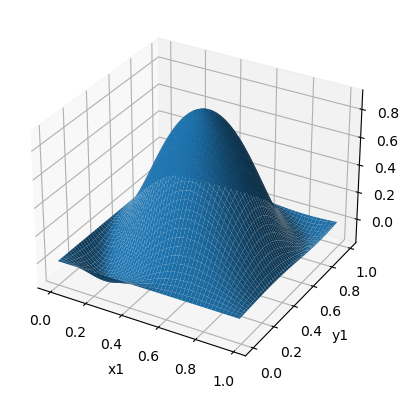

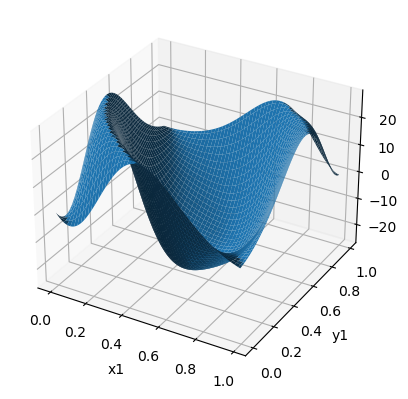

In [69]:


def make_u_f(sympy_utils,**kwargs):
    
    point=np.random.rand(2)
    max_freq=kwargs.get('max_freq',10)*sympy.pi*np.random.rand()
    lengthscale_bounds=kwargs.get('lengthscale_bounds',np.array([1e-2,2]))
    lengthscale=10**(np.log10(lengthscale_bounds[0])+np.random.rand()*(np.log10(lengthscale_bounds[1])-np.log10(lengthscale_bounds[0])))
    
    subs={'theta':0,'mu_0':point[0],'mu_1':point[1],'l':lengthscale,'l_r':1,'M_f':max_freq}
    
    u=do_eval('u',sympy_utils,subs)
    f=do_eval('f',sympy_utils,subs)
    x_sympy,y_sympy=sympy_utils['x'],sympy_utils['y']
    u=sympy.lambdify((x_sympy,y_sympy),u,'numpy')
    f=sympy.lambdify((x_sympy,y_sympy),f,'numpy')
    return u,f

def make_u_f_dir(sympy_utils,**kwargs):
    x,y=sympy.symbols('x y')
    point=np.random.rand(2)
    max_freq=kwargs.get('max_freq',10)*sympy.pi*np.random.rand()
    lengthscale_bounds=kwargs.get('lengthscale_bounds',np.array([1e-2,2]))
    lengthscale_ratio=kwargs.get('lengthscale_ratio',4)
    assert lengthscale_ratio>1
    lengthscale_ratio=10**((2*np.random.rand()-1)*np.log10(lengthscale_ratio))
    lengthscale=10**(np.log10(lengthscale_bounds[0])+np.random.rand()*(np.log10(lengthscale_bounds[1])-np.log10(lengthscale_bounds[0])))

    direction=np.random.rand()*2*np.pi
    
    
    subs={'theta':direction,'mu_0':point[0],'mu_1':point[1],'l':lengthscale,'l_r':lengthscale_ratio,'M_f':max_freq}
    
    u=do_eval('u',sympy_utils,subs)
    f=do_eval('f',sympy_utils,subs)
    x_sympy,y_sympy=sympy_utils['x'],sympy_utils['y']
    u=sympy.lambdify((x_sympy,y_sympy),u,'numpy')
    f=sympy.lambdify((x_sympy,y_sympy),f,'numpy')
    return u,f

X_sample,Y_sample=np.meshgrid(np.linspace(0,1,N_target+1,endpoint=True),np.linspace(0,1,N_target+1,endpoint=True))
sample_from_u = lambda u: u(X_sample,Y_sample)

start_time = time.time()
u_trial,f_trial=make_u_f_dir(sympy_utils)
print("--- %s seconds to substitute values---" % (time.time() - start_time))
fig = plot_function(u_trial)
fig2=plot_function(f_trial)

In [15]:
solver_fdm_asym_left=prepare_solve_poisson_fdm_inhomogeneus(
    N1=55,
    N2=55,
    L1=0.4,
    L2=0.6)
solver_fdm_asym_right=prepare_solve_poisson_fdm_inhomogeneus(
    N1=55,
    N2=55,
    L1=0.6,
    L2=0.4)
solver_fdm=prepare_fdm_poisson_solve(N=1000)
solver_GP=prepare_GP_solver(N=1000,N_target_fixed=N_target)
solver_spectral=prepare_spectral_poisson_solve(N=100)
solvers=[solver_fdm_asym_left,solver_fdm_asym_right,solver_fdm,solver_GP,solver_spectral]
names=['fdm_asym_left','fdm_asym_right','fdm','GP','spectral']

In [47]:
sols=[]
start=time.time()
for solver,name in zip(solvers,names):
    sols.append(solver(f_trial,N_target))
    print(name,time.time()-start)
    start=time.time()

fdm_asym_left 0.09575510025024414
fdm_asym_right 0.0671837329864502
fdm 0.9265000820159912
GP 0.3840358257293701
spectral 0.080841064453125


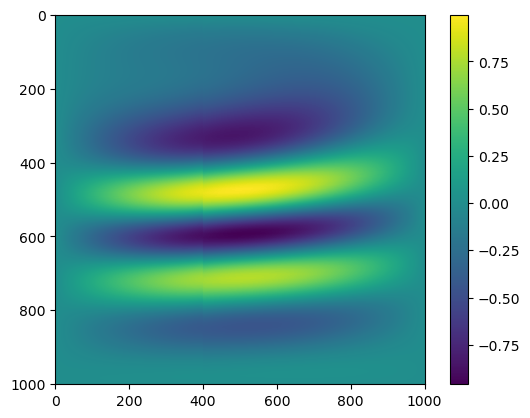

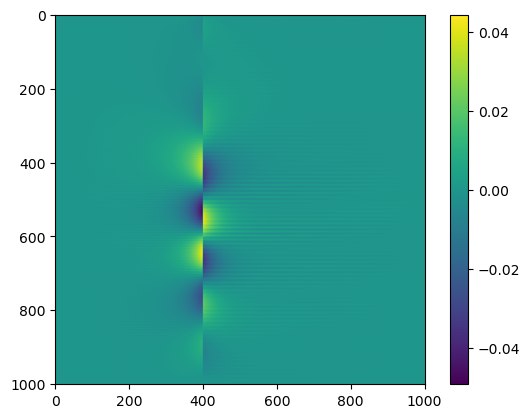

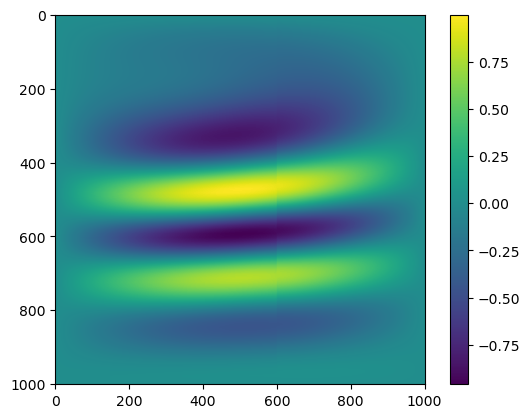

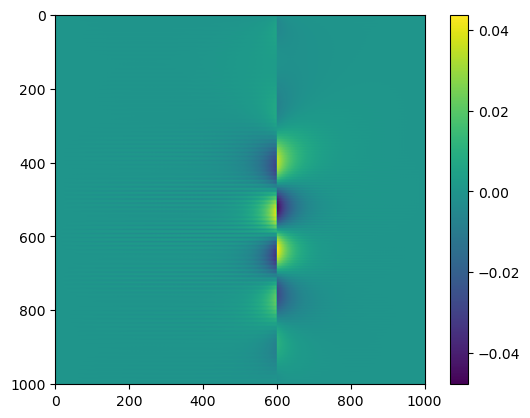

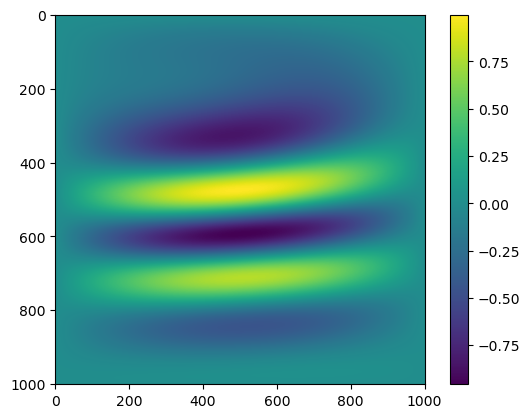

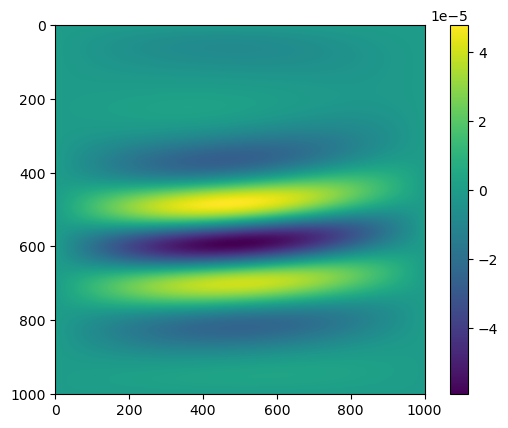

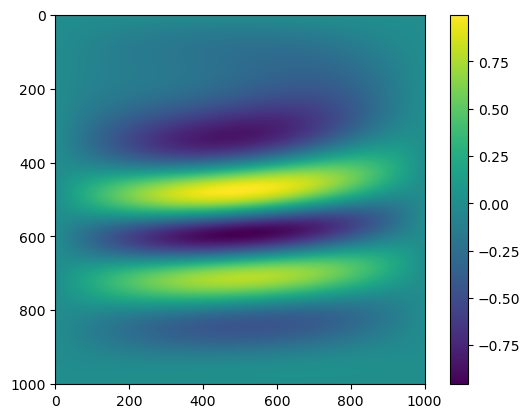

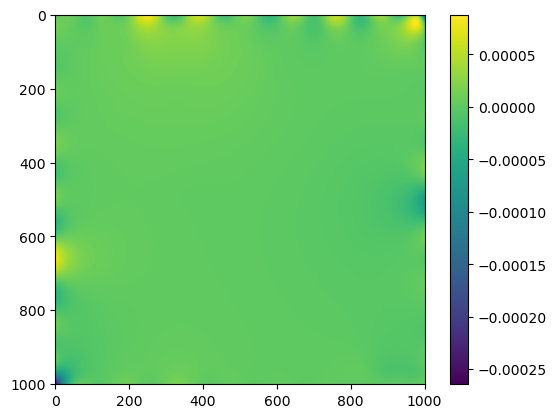

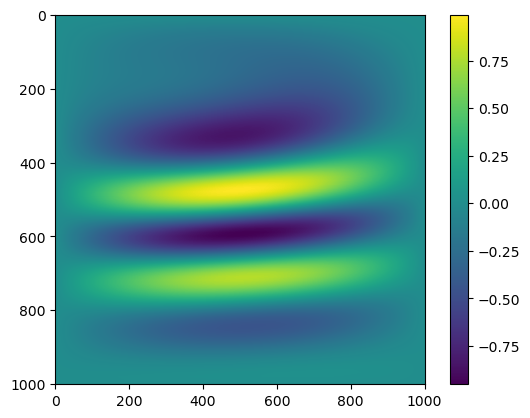

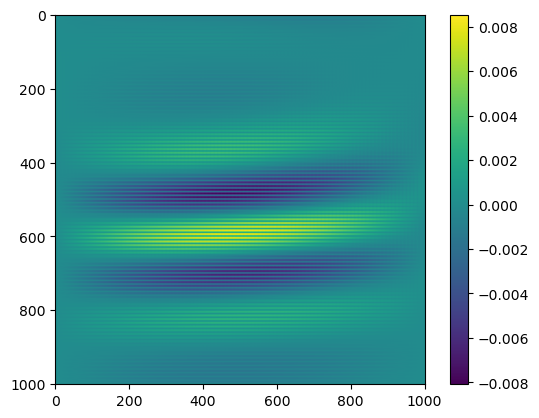

In [48]:

u_truth=sample_from_u(u_trial)
for sol in sols:
    plt.figure()
    plt.imshow(sol)
    plt.colorbar()
    plt.show()
    plt.figure()
    plt.imshow(sol-u_truth)
    plt.colorbar()
    plt.show()

In [73]:
np.random.seed(0)
UF=[make_u_f(sympy_utils) for _ in tqdm(range(1000), desc="sampling u and f")]
U=np.stack([uf[0] for uf in UF],axis=0)
F=np.stack([uf[1] for uf in UF],axis=0)


Y=np.stack([sample_from_u(u_i) for u_i in tqdm(U, desc="getting Y values")],axis=0)

getting Y values:   0%|          | 0/1000 [00:00<?, ?it/s]

In [75]:
l=np.sqrt(np.mean([np.linalg.norm(sample_from_u(fi))**2 for fi in tqdm(F)]))
l

  0%|          | 0/1000 [00:00<?, ?it/s]

4243153.55678992

In [80]:
def func_to_array(F):
    return np.stack([sample_from_u(fi) for fi in tqdm(F, desc="evaluating functions for kernel")])

In [77]:
def gaussian_separable_kernel(F_vals,G_vals=None,mat=None,l=1):
    K1=rbf_kernel(F_vals.reshape(F_vals.shape[0],-1),G_vals.reshape(G_vals.shape[0],-1),gamma=1/(2*l**2))

    return K1[:,:,None,None]*mat[None,None,:,:]+1

my_kernel=partial(gaussian_separable_kernel,mat=np.eye(len(solvers)))

In [81]:
agg=Agregator(K=my_kernel, solvers=solvers,func_to_array=func_to_array,kernel_name='gaussian',PCA_covariance_ratio=1-1e-6)

In [82]:
agg.fit(F,Y,cov_regularizer=10,alpha=0)

evaluating functions for kernel:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
pred_train,alpha_train=agg.pred_for_train(True)

In [ ]:
Y_train=np.stack([sample_from_u(u_i,N_target) for u_i in U],axis=0)
Y_train_components=agg.to_components(Y_train)

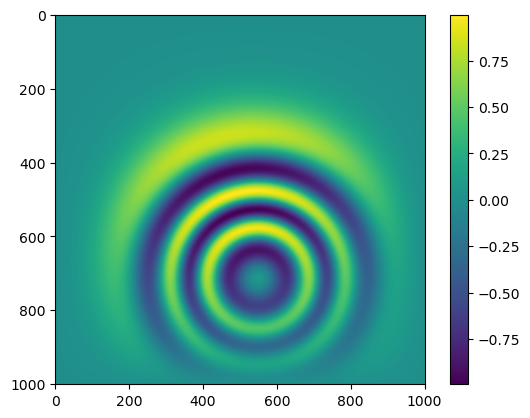

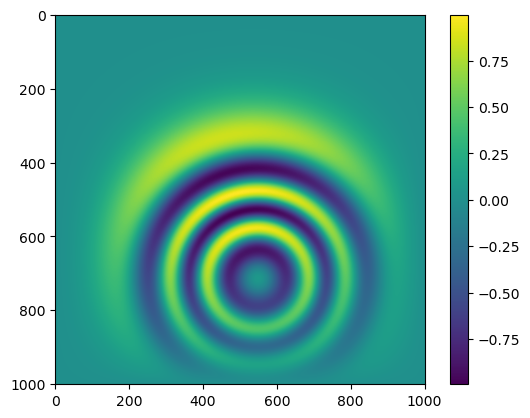

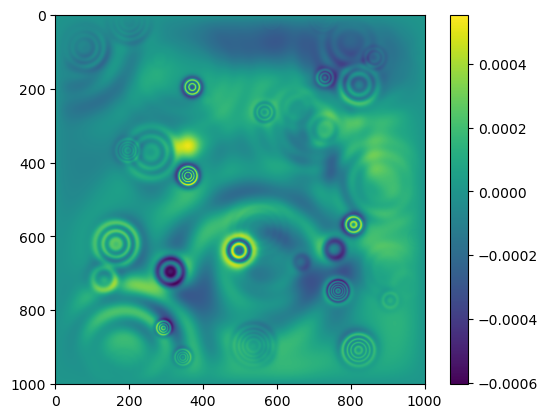

In [ ]:
index=0
timestep=index
plt.imshow(pred_train[index].reshape(N_target+1,N_target+1))
plt.colorbar()
plt.figure()
plt.imshow(sample_from_u(U[index],N_target))
plt.colorbar()
plt.figure()
plt.imshow(pred_train[index].reshape(N_target+1,N_target+1)-sample_from_u(U[index],N_target))
plt.colorbar()

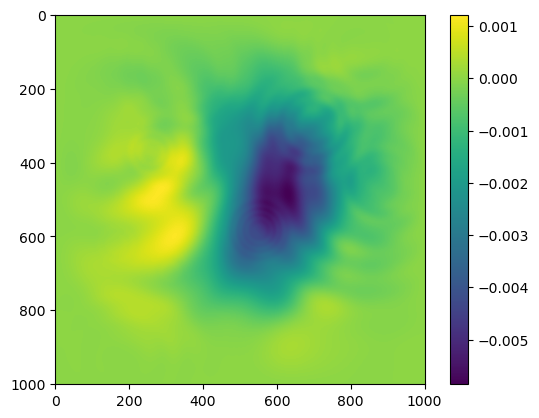

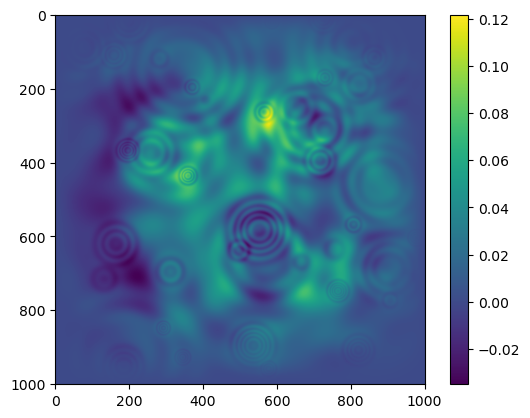

In [ ]:
vals1=np.zeros((1,93))
vals1[0,0]=1
vals2=np.zeros((1,93))
vals2[0,1]=1
plt.imshow(agg.from_components(vals1)[0]-agg.from_components(vals2)[0])
plt.colorbar()
plt.figure()
plt.imshow(agg.from_components(vals2)[0])
plt.colorbar()

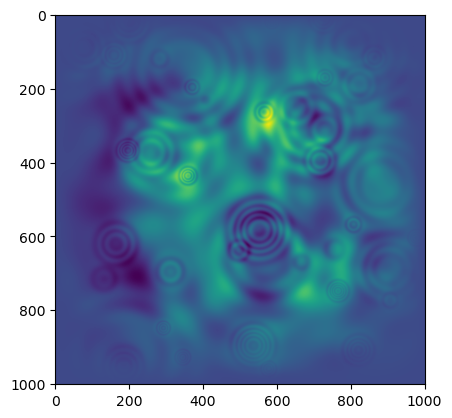

In [ ]:
plt.imshow(np.mean(Y_train,axis=0))

In [ ]:
pred_components_train=agg.to_components(pred_train)

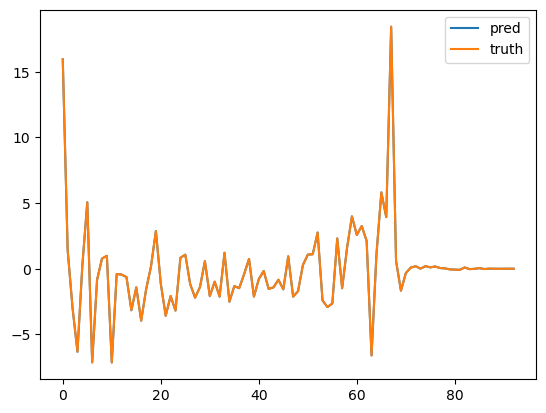

In [ ]:
i=np.random.randint(100)
plt.plot(pred_components_train[i],label='pred')
plt.plot(Y_train_components[i],label='truth')
plt.legend()

In [ ]:
np.random.seed(4)
UF_to_test=[make_u_f() for _ in range(10)]
U_to_test=np.stack([uf[0] for uf in UF_to_test],axis=0)
F_to_test=np.stack([uf[1] for uf in UF_to_test],axis=0)

0.441380398895241 9.72684359964884*pi [0.96702984 0.54723225]
0.010335607397621106 9.76274454776242*pi [0.69772882 0.2160895 ]
0.028502259272611838 7.79382921793752*pi [0.25298236 0.43479153]
0.23685541738809032 1.63842241404699*pi [0.86299324 0.98340068]
1.5895975112550305 0.441600579314996*pi [0.0089861  0.38657128]
0.984821816766128 7.86305985935061*pi [0.43614665 0.94897731]
0.024350564477471807 6.00742721377769*pi [0.17316542 0.07494859]
1.4367471282778608 5.2790882341792*pi [0.73338017 0.40844386]
0.17969155016767324 1.58223407184799*pi [0.52169612 0.10819338]
0.3127670883874413 4.01495443590273*pi [0.52440408 0.63761024]


In [ ]:
pred,alpha=agg(F_to_test,True)

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 93) (5, 10, 93) (10, 5, 93)


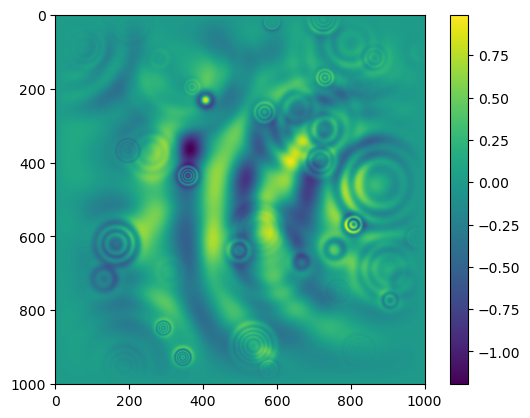

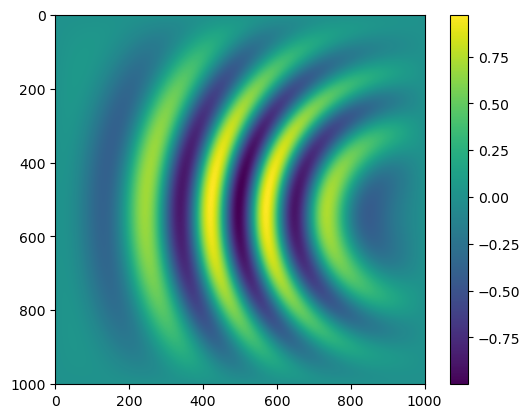

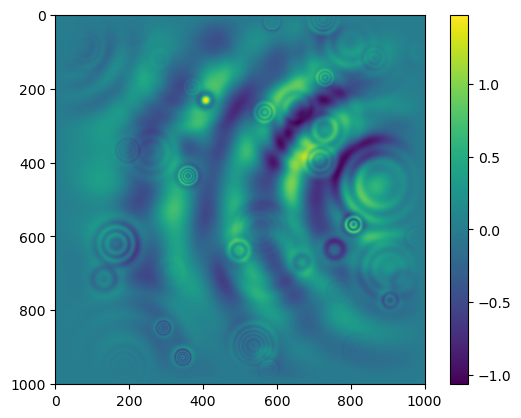

In [ ]:
index=0
timestep=index
plt.imshow(pred[index].reshape(N_target+1,N_target+1))
plt.colorbar()
plt.figure()
plt.imshow(sample_from_u(U_to_test[index],N_target))
plt.colorbar()
plt.figure()
plt.imshow(pred[index].reshape(N_target+1,N_target+1)-sample_from_u(U_to_test[index],N_target))
plt.colorbar()

In [ ]:
Y_to_test=np.stack([sample_from_u(u_i,N_target) for u_i in U_to_test],axis=0)
Y_components_to_test=agg.to_components(Y_to_test)

In [ ]:
pred_components=agg.to_components(pred)
model_to_test=agg.call_models(F_to_test)
model_transforms_to_test_agg=agg.to_components(model_to_test)

  0%|          | 0/10 [00:00<?, ?it/s]

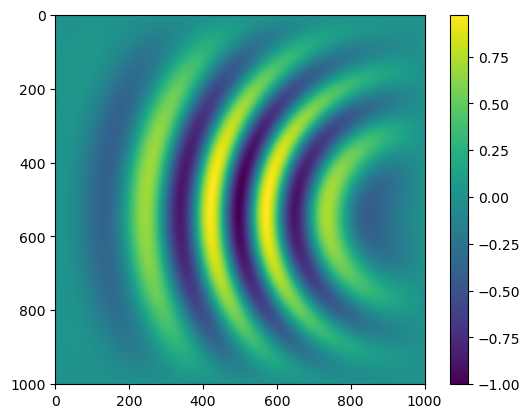

In [ ]:
plt.imshow(model_to_test[0,2].reshape(N_target+1,N_target+1))
plt.colorbar()

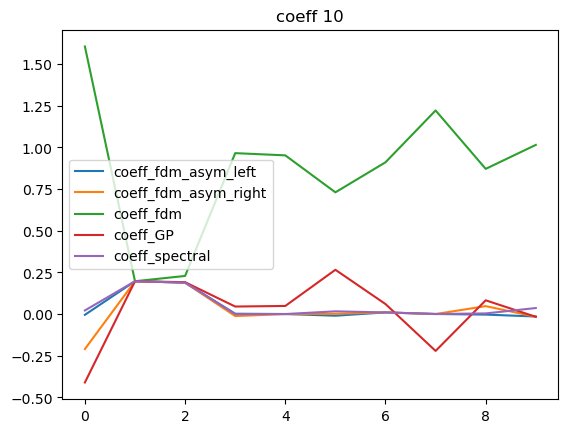

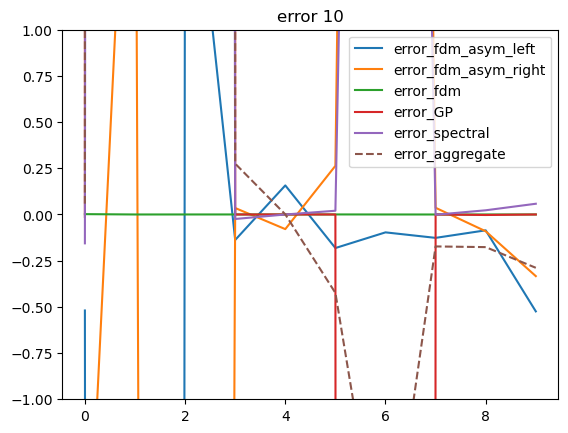

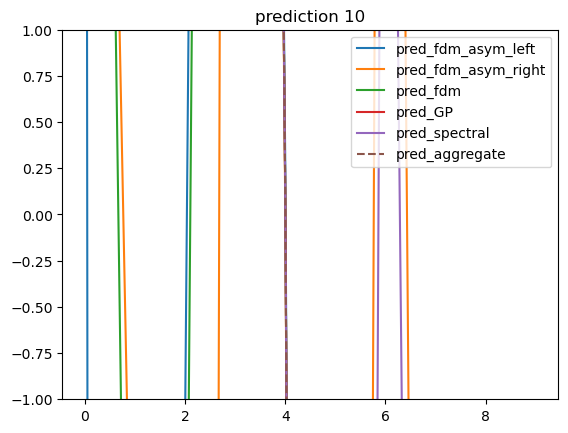

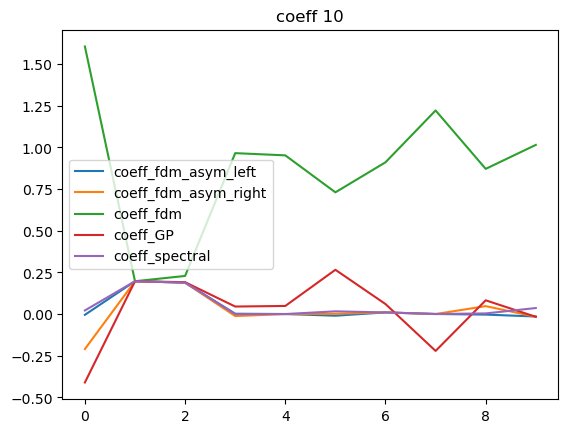

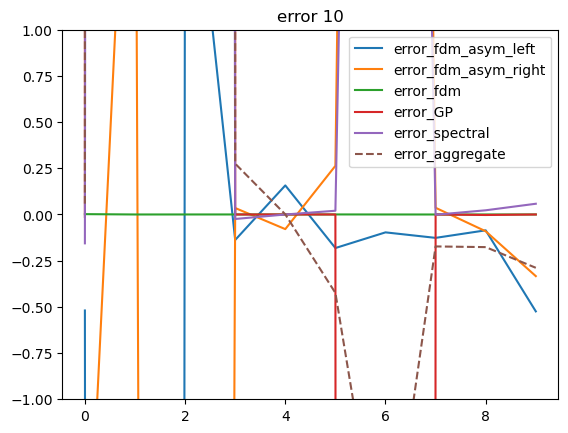

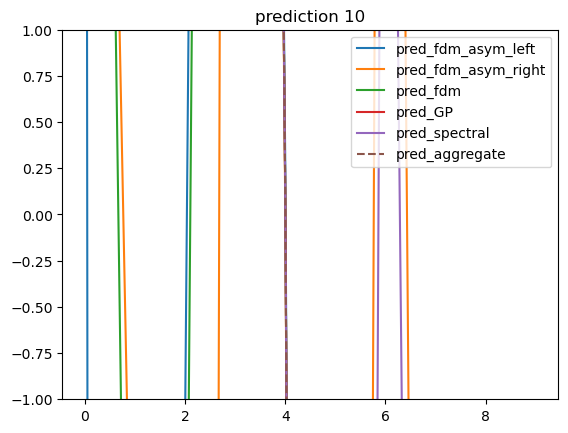

In [ ]:
for freq in np.random.randint(0,50,2):
    plt.figure()
    for i in range(5):
        plt.plot(alpha[i,:,freq],label='coeff_'+names[i])
    plt.legend()
    plt.title(f'coeff {freq}')
    plt.figure()
    for i in range(5):
        plt.plot(model_transforms_to_test_agg[:,i,freq]-Y_components_to_test[:,freq],label='error_'+names[i])
    plt.plot(pred_components[:,freq]-Y_components_to_test[:,freq],label='error_aggregate',linestyle='--')
    plt.ylim(-1,1)
    plt.legend()
    plt.title(f'error {freq}')
    plt.figure()
    for i in range(5):
        plt.plot(model_transforms_to_test_agg[:,i,freq],label='pred_'+names[i])
    plt.plot(pred_components[:,freq],label='pred_aggregate',linestyle='--')
    plt.ylim(-1,1)
    plt.legend()
    plt.title(f'prediction {freq}')